# Code to create figure A.1.1:
### ERA 5 and PRISM precipitation comparison: Region scatter plots

Used in the manuscript,  
Evaporative Moisture Sources of Colorado’s Front Range: A Case Study of the Exceptionally Wet May-July Season of 2023

In [1]:
#Import Statements
import xarray as xr
import numpy as np
import xesmf as xe
import glob
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import warnings
import seaborn as sns
from sklearn.metrics import r2_score
from string import ascii_lowercase

warnings.filterwarnings("ignore") #ignore cartopy warnings when plotting

#DIRECTORIES---------
prism_directory = '/Users/kathum/Research/COPEX/aggregated_files/prism'
era5_directory = '/Users/kathum/Research/COPEX/aggregated_files/era5'
#areagrid directories (netCDFs of each grid's cell area in m^2
prism_area_path = '/Users/kathum/Research/area_grids/prism_4km_area.nc'
era5_area_path = '/Users/kathum/Research/area_grids/quarter_degree_area_grid_m_nHemisphere.nc'
#source region directories
region_mask_path = '/Users/kathum/Research/COPEX/aggregated_files/dryad_data_repo/region_masks/'

#function to extract dates from a PRISM file's pathname and assign a cordinate
def extract_date(ds):
    grid_time = pd.to_datetime(ds.encoding['source'].split('_')[-2],format="%Y%m")
 
    # print(grid_time)
    return ds.assign(time=grid_time)

#create a shaply feature from a shapefile path and a specific projection
def add_shapefile(path, projection):
    reader = shpreader.Reader(path)
    shapes = list(reader.geometries())
    shapely_shapes = cfeature.ShapelyFeature(shapes, projection)
    return shapely_shapes

#function to label subplots 
def label_subplots(axis, index):
    axis.text(0, 1.075, f'({ascii_lowercase[index]})', transform=axis.transAxes,fontsize=14, 
               va='top', ha='left', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

#automatically determine the appropriate extend for matplotlib colorbar   
def get_colorbar_extend(data, vmin_val, vmax_val):
    data_min = np.round(np.nanmin(data).item())
    data_max = np.nanmax(data).item()

    if data_min < vmin_val and data_max > vmax_val:
        return 'both'
    elif data_min < vmin_val:
        return 'min'
    elif data_max > vmax_val:
        return 'max'
    else:
        return 'neither'

## Read in PRISM and ERA5 datasets + other files needed for analysis

In [2]:
data_extent = [-111.0,-100.0,35,43] #min lon, max lon, min lat, max lat
colorado_extent = [-109.25, -101.75, 36.5, 41.5] #min lon, max lon, min lat, max lat
#---------------------------------Prism Data---------------------------------
#read prism area
prism_area_da = xr.open_dataarray(prism_area_path).sel(lon=slice(data_extent[0], data_extent[1]),lat=slice(data_extent[2], data_extent[3]))# in m^2

#read prism data and prep
files = sorted(glob.glob(f'{prism_directory}/PRISM_ppt_*_bil.nc'))
prism_ds_mm = xr.open_mfdataset(files,concat_dim='time',combine='nested',preprocess=extract_date)['Band1'].sel(lon=slice(data_extent[0], data_extent[1]),
                                                                                                            lat=slice(data_extent[2], data_extent[3]))
prism_ds_m3 = (prism_ds_mm/1000)*prism_area_da #in m^3

#---------------------------------Era5 Data---------------------------------
#read era5 area grid and prep
era5_area_da = xr.open_dataarray(era5_area_path).sel(longitude=slice(data_extent[0]+360, data_extent[1]+360),latitude=slice(data_extent[3], data_extent[2])) # in meters^2
era5_area_da = era5_area_da.rename({'latitude': 'lat', 'longitude': 'lon'}) #rename latitude and longitude variables to lat and lon

#read era5 and prep
files = sorted(glob.glob(f'{era5_directory}/*.nc'))
era5_ds_mm = (xr.open_mfdataset(files)['tp']*1000).sel(longitude=slice(data_extent[0]+360, data_extent[1]+360),latitude=slice(data_extent[3], data_extent[2])) #in meters
era5_ds_mm = era5_ds_mm.rename({'latitude': 'lat', 'longitude': 'lon'}) #rename latitude and longitude variables
era5_ds_m3 = (era5_ds_mm/1000 )* era5_area_da #in m^3

#---------------------------------Read counties shapefiles for plotting---------------------------------
CO_counties = add_shapefile('/Users/kathum/Research/COPEX/sink_region_files/sink_region_shp/lm_cnty/lm_cnty.shp',ccrs.PlateCarree())


## Regrid PRISM (higher resolution) to ERA5 grid (coarser)

In [3]:
# Create regridder (assumes lat/lon names are standard: lat, lon)
regridder = xe.Regridder(prism_ds_mm, era5_ds_mm, method='conservative')
#regrid preism data to era5
prism_ds_coarse = regridder(prism_ds_mm) #coarse mm
prism_ds_coarse_m3 = ((prism_ds_coarse/1000)*era5_area_da)

## Calculate region total precipitation for both datasets to compare

In [4]:
#source regions files list
east_co_regions = ['Northeast', 'Northern_Front_Range', 'Pikes_Peak', 'South_Park', 'Southeast']
files = []
for east_co_region in east_co_regions:
    files.append(f'{region_mask_path}/co_AltClimate_{east_co_region}_source_region.nc')
files = sorted(files)

#hold regional precip in a dictionary
region_precip = {}
region_names = []

for region_path in files:
    #read in region mask
    region_mask = xr.open_dataarray(region_path).rename({'latitude': 'lat', 'longitude': 'lon'})
    region_name = region_path.split("co_AltClimate_")[1].split("_source_region.nc")[0].lower()
    #collect region names for later use
    if region_name not in region_names:
        region_names.append(region_name)
    #calculate total area of source region
    region_area = (era5_area_da.where(region_mask>0)).sum(['lat','lon']).values #in m^2    
    #------------Prism Calc------------
    region_prism_m3 = (prism_ds_coarse_m3.where(region_mask>0)).sum(['lat','lon'])
    region_prism_mm = (region_prism_m3/region_area)*1000
    #append data to precip dictionary
    region_precip[f'{region_name}_prism'] = list(region_prism_mm.values)
    #------------Era5 Calc------------
    region_era5_m3 = (era5_ds_m3.where(region_mask>0)).sum(['lat','lon'])
    region_era5_mm = (region_era5_m3/region_area)*1000
    #append data to precip dictionary
    region_precip[f'{region_name}_era5'] = list(region_era5_mm.values)
    
    region_mask.close()

#convert dictionary to data frame
region_precip = pd.DataFrame(region_precip)

#alter the dataframe structure for analysis purposes--
# Sort columns by region name (alphabetically)
region_precip = region_precip[sorted(region_precip.columns)]
#add new columns
region_precip['date'] = list(era5_ds_mm.time.values)
region_precip['month_year'] = [f'{date.month:02}_{date.year}' for date in pd.to_datetime(era5_ds_mm.time.values)]
region_precip['month'] = era5_ds_mm.time.dt.month.values
region_precip['year'] = era5_ds_mm.time.dt.year.values
#take column name and seperate out region and precip dataset
region_precip_long = region_precip.melt(
    id_vars=['date', 'month_year','month','year'],       # keep date info as columns
    var_name='region_data',             # new column for old column names
    value_name='precip')                   # new column for values
#split the 'region_data' column into 'region' and 'data'
region_precip_long[['region', 'data']] = region_precip_long['region_data'].str.rsplit('_', n=1, expand=True)
# reorder columns for readability
region_precip_long = region_precip_long[['date', 'month_year', 'month','year', 'region', 'data', 'precip']]

## Plotting

            northeast: y=0.89x + 16.87
 northern_front_range: y=0.85x + 0.68
           pikes_peak: y=0.97x + 5.48
           south_park: y=0.88x + -9.54
            southeast: y=1.01x + 7.62


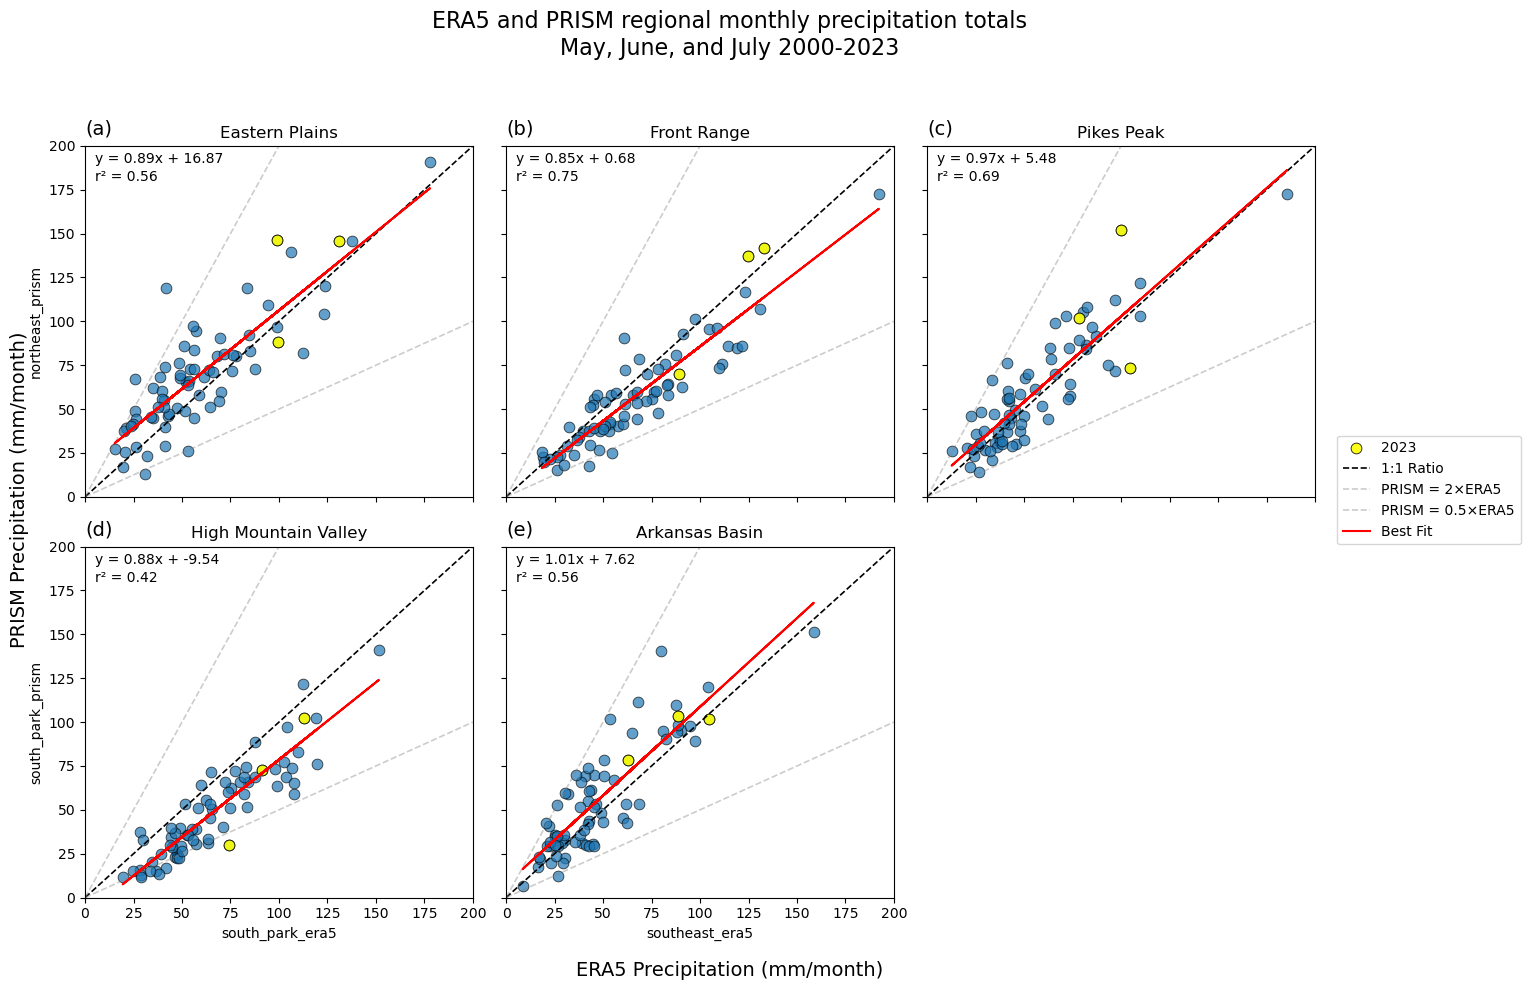

In [5]:
# Grid layout (adjust cols as needed)
region_names_sel = region_names#list(filter(lambda x: x!='northern_front_range', region_names))
ncols = 3
nrows = int(np.ceil(len(region_names_sel) / ncols))
warm_season_only = True
alt_region_names = {'northern_front_range':'Front Range', 'northeast':'Eastern Plains', 'southeast':'Arkansas Basin','south_park':'High Mountain Valley', 
                    'pikes_peak':'Pikes Peak'}

# Create figure and axes
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows), sharex=True, sharey=True)
axes = axes.flatten()

# Loop through each region
for i, region in enumerate(region_names_sel):
    ax = axes[i]

    if warm_season_only:
        x = region_precip.loc[(region_precip.month>4)&(region_precip.month<8)][f'{region}_era5']
        y = region_precip.loc[(region_precip.month>4)&(region_precip.month<8)][f'{region}_prism']
        x_2023 = region_precip.loc[(region_precip.month>4)&(region_precip.month<8)&(region_precip.year ==2023)][[f'{region}_era5', 'date']]
        y_2023 = region_precip.loc[(region_precip.month>4)&(region_precip.month<8)&(region_precip.year ==2023)][[f'{region}_prism', 'date']]

    else:
        x = region_precip[f'{region}_era5']
        y = region_precip[f'{region}_prism']
    hue = region_precip['month']

    # Scatter plot
    sns.scatterplot(
        x=x,
        y=y,
        # hue=hue,
        # palette='hsv',
        s=60,
        edgecolor='black',
        alpha=0.7,
        ax=ax
    )
    sns.scatterplot(
        x=x_2023[f'{region}_era5'],
        y=y_2023[f'{region}_prism'],
        s=60,
        edgecolor='black',
        color='yellow',
        alpha=0.9,
        ax=ax,
        label='2023',
        legend=False  
    )
    # 1:1 line
    lims = [0, 200]
    ax.plot(lims, lims, 'k--', linewidth=1.2, label='1:1 Ratio')
    # Add PRISM = 2 × ERA5 (overestimation)
    ax.plot(lims, [2 * l for l in lims], 'gray', linestyle='--', linewidth=1.2, alpha=0.4, label='PRISM = 2×ERA5')

    # Add PRISM = 0.5 × ERA5 (underestimation)
    ax.plot(lims, [0.5 * l for l in lims], 'gray', linestyle='--', linewidth=1.2, alpha=0.4, label='PRISM = 0.5×ERA5')

    #add best fit line 
    a, b = np.polyfit(x, y, 1)
    ax.plot(x, a*x+b, 'red', label='Best Fit')
    ax.annotate(f'y = {a:.02f}x + {b:.2f}', (5, 190))
    print(f'{region: >21}: y={a:.02f}x + {b:.2f}')
    
    
    #add r^2 value
    ax.annotate(f"r² = {r2_score(x, y):.2f}", (5, 180))
    
    #set scatter plot limits    
    ax.set_xlim(0, 200)
    ax.set_ylim(0, 200)
    #title
    ax.set_title(alt_region_names[region])#region.replace('_', ' ').title())
    label_subplots(axis = ax, index = i)

# Remove empty axes if total < grid size
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Shared axis labels
fig.supxlabel("ERA5 Precipitation (mm/month)", fontsize=14)
fig.supylabel("PRISM Precipitation (mm/month)", fontsize=14)

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.9, 0.5), loc="center left")

#save plot
if warm_season_only:
    title = f'ERA5 and PRISM regional monthly precipitation totals\nMay, June, and July 2000-2023'
    file_name= '/Users/kathum/Research/COPEX/figures/era5_prism_monthly_scatterplot_mjj.png'
else:
    title = "Comparison of ERA5 and PRISM regional monthly precipitation totals\nJanuary 2000-September 2023"
    file_name= '/Users/kathum/Research/COPEX/figures/era5_prism_monthly_scatterplot.png'
fig.suptitle(title, fontsize=16)

plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust for legend and title
plt.savefig(file_name,bbox_inches='tight',dpi=300)